# Frame Overlap Tutorial (v0.2.0)

This tutorial demonstrates the frame_overlap package for analyzing neutron Time-of-Flight frame overlap data.

## Overview

The package provides four main classes:

1. **Data**: Load and process ToF data
2. **Reconstruct**: Apply deconvolution filters
3. **Analysis**: Simplified nbragg integration
4. **ParametricScan**: Parameter sensitivity analysis

## CORRECT Workflow Order:

```
Data → Convolute → Poisson → Overlap → Reconstruct → Analysis
        ↓           ↓          ↓          ↓           ↓
    Instrument  Add noise  Frame ops  Recover     Fit with
     response   (+ flux              signal      nbragg
                scaling)
```

**KEY INSIGHT**: Convolute BEFORE Poisson!

Why? The pulse_duration defines the pulsed source duty cycle:
- `effective_flux = flux × pulse_duration × freq`
- Flux is measured for continuous source, but measurement is pulsed
- Convolute stores pulse_duration, Poisson uses it automatically

## New Features in v0.2.0:
- **Automatic flux scaling** by pulse_duration in Poisson
- **tmin/tmax filtering**: Calculate chi² on specific time/wavelength range
- **Vertical indicators**: Show tmin/tmax on plots
- **Two-subplot plotting**: Data + residuals in σ units
- **nbragg integration**: `recon.to_nbragg()` for wavelength conversion
- **Analysis class**: Clean API for nbragg fitting
- **Noise optimization**: `recon.optimize_noise()` with lmfit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from frame_overlap import Data, Reconstruct, Analysis

%matplotlib inline

## 1. Data Loading

Load signal and openbeam data from CSV files.

In [2]:
# Load data
data = Data(
    signal_file='iron_powder.csv',
    openbeam_file='openbeam.csv',
    flux=1e6,       # n/cm²/s (continuous source)
    duration=1.0,   # hours
    freq=20,        # Hz
    threshold=0
)

print(data)
print(f"\nLoaded {len(data.table)} data points")
print(f"Time range: {data.table['time'].min():.1f} - {data.table['time'].max():.1f} µs")

Data(n_points=2400, stage='original', has_openbeam=True, kernel=None)

Loaded 2400 data points
Time range: 0.0 - 23990.0 µs


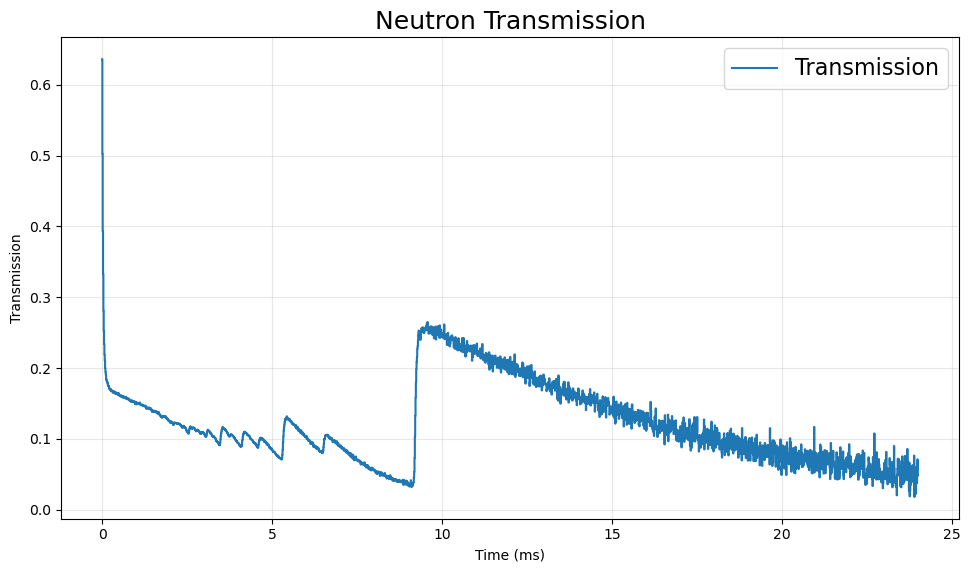

In [3]:
# Visualize raw data
data.plot()
plt.show()

## 2. Instrument Response Convolution (FIRST!)

Apply convolution to simulate the instrument's pulse duration.

**IMPORTANT**: This step stores `pulse_duration`, which will be used by `poisson_sample()` to calculate effective flux.

In [4]:
# Convolute with 200 µs pulse
data.convolute_response(pulse_duration=200)

print(f"Convolution applied with pulse_duration = {data.pulse_duration} µs")
print(f"Data shape: {data.table.shape}")

Convolution applied with pulse_duration = 200 µs
Data shape: (2400, 3)


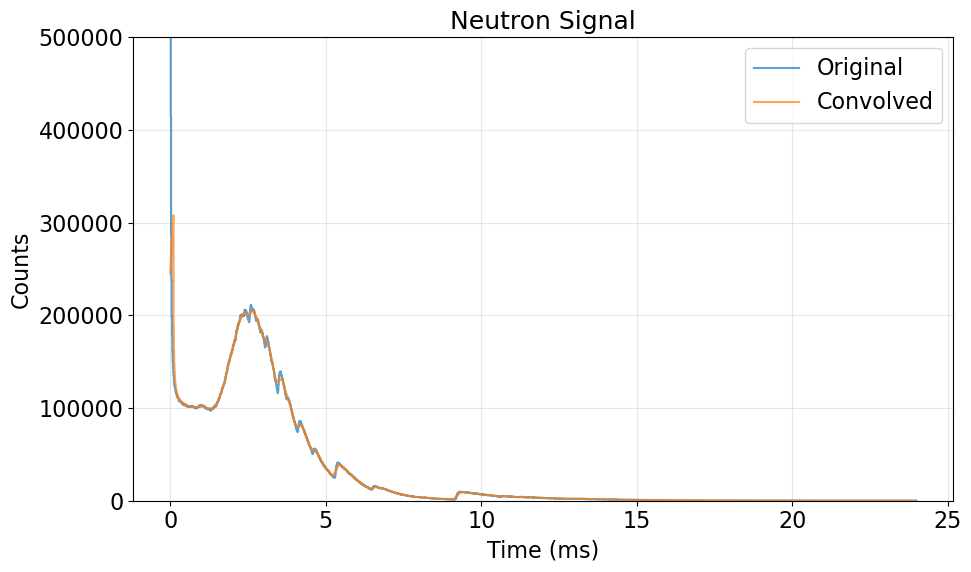

In [5]:
# Visualize convolved data
data.plot(kind="signal",show_stages=True, show_errors=False,ylim=(0,5e5));

## 3. Poisson Sampling (AFTER Convolution!)

Apply Poisson sampling to simulate neutron counting statistics.

**Automatic flux scaling**: Since `pulse_duration` and `freq` are known, the effective flux is:
```
flux_eff = flux × (pulse_duration / 1e6) × freq
         = 1e6 × (200e-6) × 20
         = 4000 n/cm²/s
```

In [6]:
# Apply Poisson sampling
# flux is automatically scaled by pulse_duration × freq
data.poisson_sample(flux=1e6, measurement_time=240, freq=20)

print("Poisson sampling applied")
print(f"Data shape: {data.table.shape}")

Pulse duration scaling applied: 200 µs
Duty cycle calculation for PULSED source:
  duty_cycle = (flux_new / flux_orig) × freq_new × pulse_duration
  duty_cycle = (1.00e+06 / 1.00e+06) × 20 × 200e-6
  duty_cycle = 1.0000 × 20 × 0.000200
  duty_cycle = 0.004000
Poisson sampling applied
Data shape: (2400, 3)


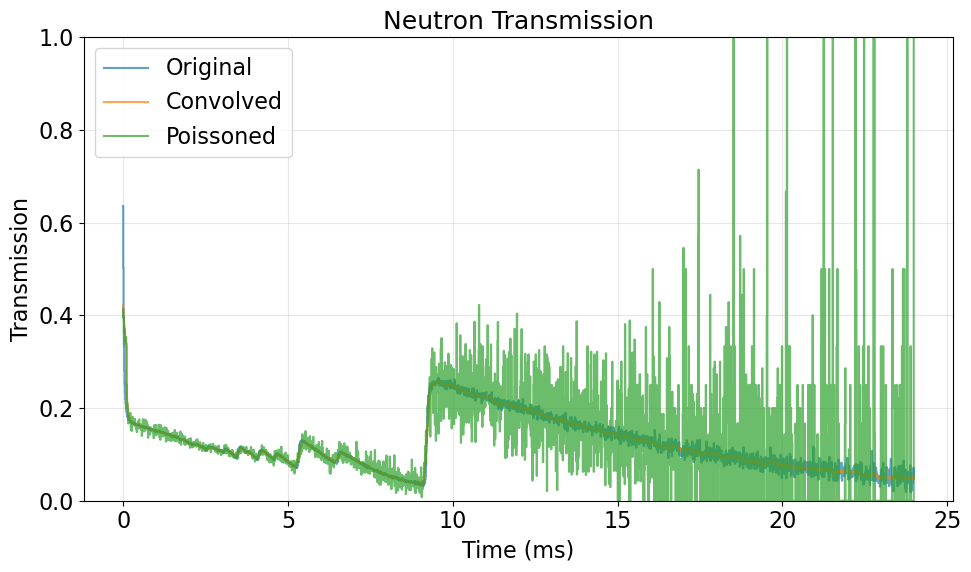

In [7]:
data.plot(kind="transmission",show_stages=True, show_errors=False,ylim=(0,1));

## 4. Frame Overlap

Create overlapping frames. Example: `[0, 25]` means:
- Frame 1 starts at t = 0 ms
- Frame 2 starts at t = 25 ms

**Optional**: Use `poisson_seed` to add randomness to the overlapped signal with duty_cycle=1.0

In [8]:
# Create 2-frame overlap
data.overlap(kernel=[0, 25], total_time=50)

print(f"Frame overlap created with kernel: {data.kernel}")
print(f"  Frame 1 starts at: 0 ms")
print(f"  Frame 2 starts at: 25 ms")
print(f"New data length: {len(data.table)}")

Frame overlap created with kernel: [0, 25]
  Frame 1 starts at: 0 ms
  Frame 2 starts at: 25 ms
New data length: 5000


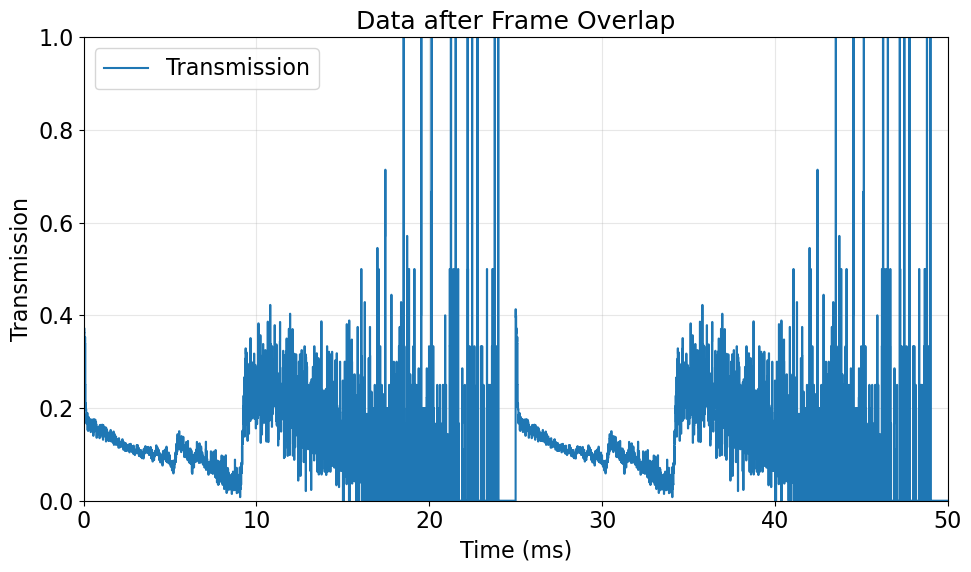

In [9]:
# Plot overlapped data
data.plot(kind="transmission", show_errors=False,ylim=(0,1),xlim=(0,50))
plt.title('Data after Frame Overlap')
plt.show()

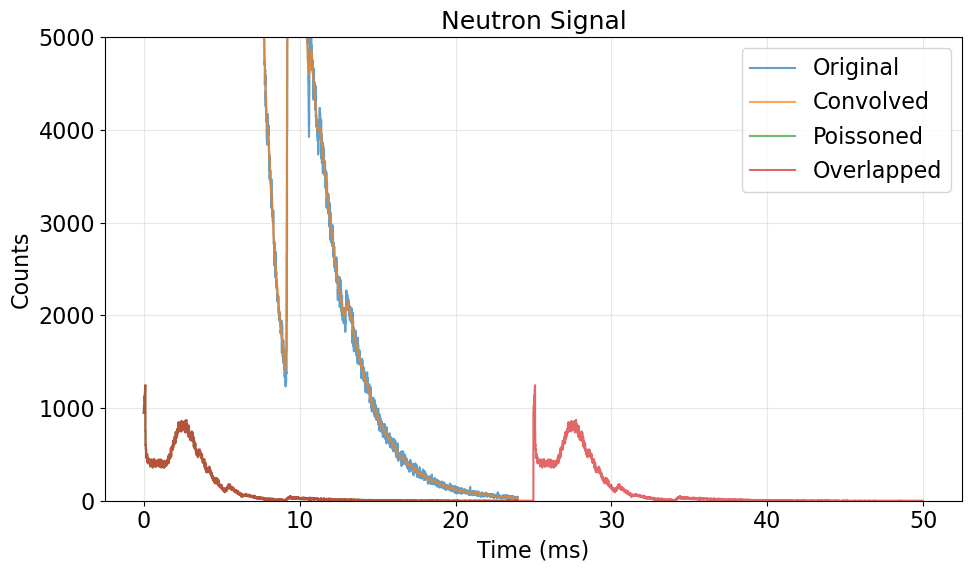

In [10]:
data.plot(kind="signal",show_stages=True, show_errors=False,ylim=(0,5e3));

## 5. Signal Reconstruction

Apply deconvolution to recover the poissoned+convolved signal (before overlap).

**NEW**: Specify `tmin` and `tmax` (in ms) to calculate chi² only on a specific time range!

In [11]:
# Create Reconstruct object
# Example with tmin/tmax: recon = Reconstruct(data, tmin=10, tmax=40)
recon = Reconstruct(data,tmin=1,tmax=6)

# Apply Wiener filter
recon.filter(kind='wiener', noise_power=0.01)

print("Reconstruction complete!")
print(f"\nWhat we recovered: Poissoned+Convolved signal (before overlap)")
print(f"Reference shape: {recon.reference_data.shape}")
print(f"Reconstructed shape: {recon.reconstructed_data.shape}")

print(f"\nReconstruction Statistics:")
for key, value in recon.get_statistics().items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Reconstruction complete!

What we recovered: Poissoned+Convolved signal (before overlap)
Reference shape: (2400, 3)
Reconstructed shape: (5000, 3)

Reconstruction Statistics:
  chi2: 21.0042
  chi2_per_dof: 0.0419
  r_squared: 0.9996
  rmse: 4.8405
  nrmse: 0.0061
  n_points: 501
  tmin: 1
  tmax: 6


### Visualize Reconstruction

Two-subplot layout:
- **Top**: Poissoned+Convolved (target) vs Reconstructed
- **Bottom**: Residuals in σ units

**NEW**: Green/orange vertical lines show tmin/tmax if specified!

/opt/conda/lib/python3.13/site-packages/frame_overlap/reconstruct.py:728: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


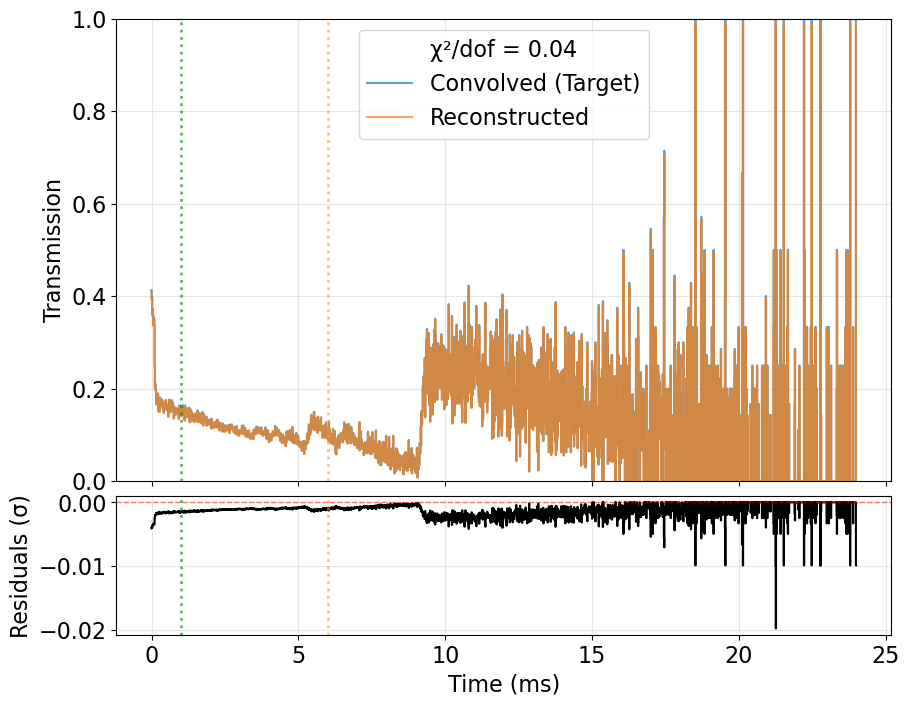

In [12]:
# Plot reconstruction results
recon.plot(kind='transmission', show_errors=False,ylim=(0,1))
plt.show()

/opt/conda/lib/python3.13/site-packages/frame_overlap/reconstruct.py:728: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


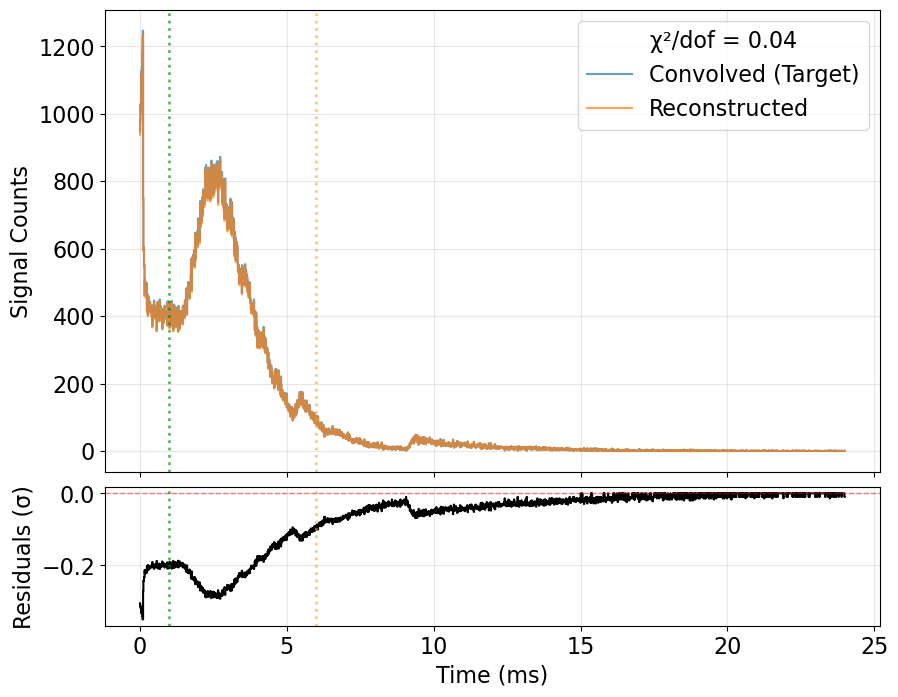

In [13]:
# Plot signal counts
recon.plot(kind='signal', show_errors=False)
plt.show()

### Automatic Noise Optimization

Use `optimize_noise()` to find the optimal noise_power parameter.

Optimizing noise_power for wiener filter...
  Range: [1.00e-04, 1.00e+00]

Optimization complete!
  Optimal noise_power: 1.0000e-04
  Chi-squared: 0.00
  Reduced chi-squared: 0.00

Optimal noise_power: 1.0000e-04
Chi-squared: 0.00


/opt/conda/lib/python3.13/site-packages/frame_overlap/reconstruct.py:728: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


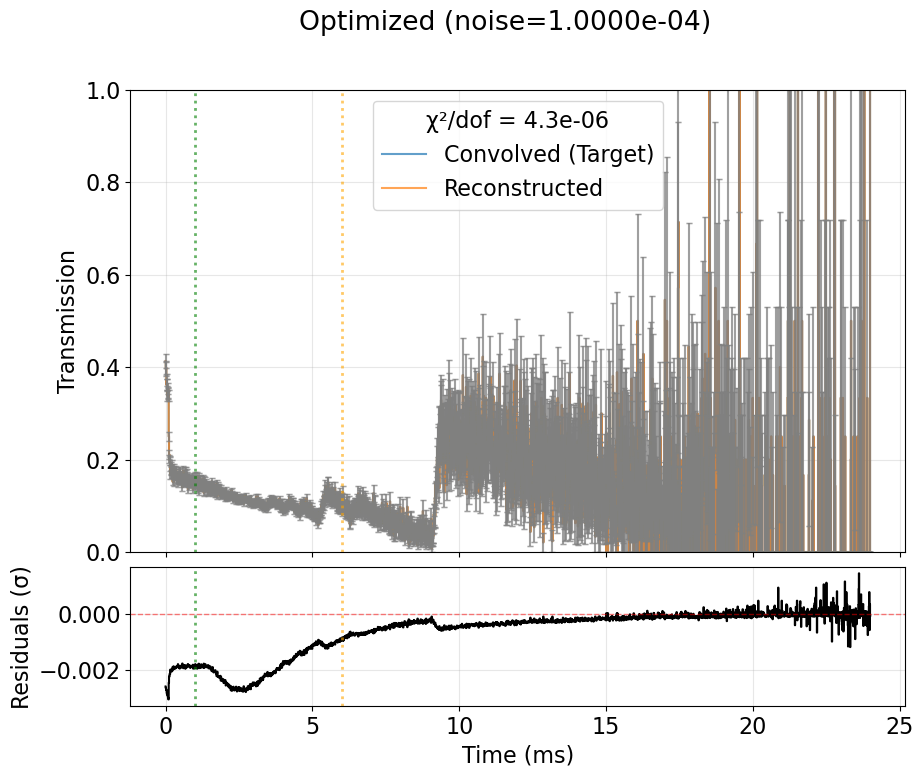

In [14]:
# Optimize noise parameter
try:
    result = recon.optimize_noise(
        kind='wiener',
        noise_min=1e-4,
        noise_max=1.0,
        method='leastsq'
    )
    
    print(f"\nOptimal noise_power: {result.params['noise_power'].value:.4e}")
    print(f"Chi-squared: {result.chisqr:.2f}")
    
    # Plot optimized reconstruction
    recon.plot(kind='transmission', show_errors=True,ylim=(0,1))
    plt.suptitle(f"Optimized (noise={result.params['noise_power'].value:.4e})")
    plt.show()
except ImportError:
    print("lmfit not installed - install with: pip install lmfit")

In [15]:
result

## 6. nbragg Integration

Convert reconstructed data to nbragg format and fit.

In [16]:
# Convert to nbragg format
nbragg_data = recon.to_nbragg(L=9.0, tstep=10e-6)
print(f"✓ Converted to nbragg.Data")
print(f"  Type: {type(nbragg_data)}")

✓ Converted to nbragg.Data
  Type: <class 'nbragg.data.Data'>


/opt/conda/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='wavelength'>

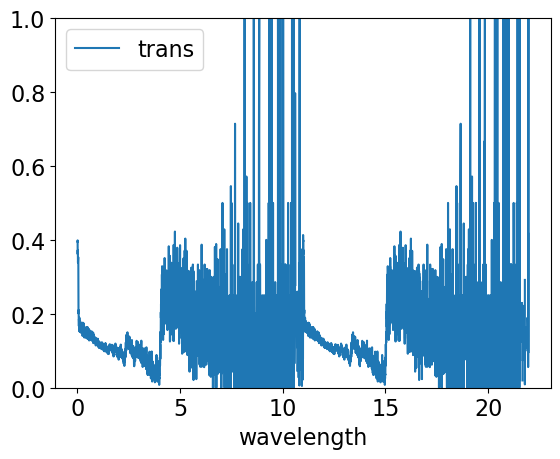

In [17]:
nbragg_data.table.plot(x="wavelength",y="trans",ylim=(0,1))

Analysis object created
Access nbragg model: analysis.model.params


/opt/conda/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rietveld Fit:   0%|          | 0/3 [00:00<?, ?it/s]


Fit complete!
Reduced chi-squared: 1.220


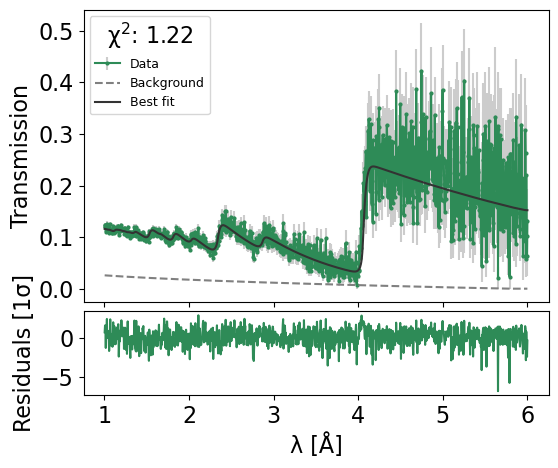

In [18]:

analysis = Analysis(xs='iron', vary_background=True,vary_response=True)

print("Analysis object created")
print(f"Access nbragg model: analysis.model.params")

# Fit
result = analysis.fit(recon)

print(f"\nFit complete!")
print(f"Reduced chi-squared: {result.redchi:.3f}")

# Plot
analysis.plot()
plt.show()

In [19]:
analysis.result

## 7. Method Chaining

Complete workflow in one chain with CORRECT order.

In [20]:
# Method chaining with CORRECT order
data_chain = (Data(signal_file='iron_powder.csv', 
                   openbeam_file='openbeam.csv',
                   flux=1e6, duration=1.0, freq=20)
              .convolute_response(200)              # 1. Convolute (stores pulse_duration)
              .poisson_sample(flux=1e6,             # 2. Poisson (uses pulse_duration)
                             measurement_time=1.0, 
                             freq=20)
              .overlap([0, 25]))                    # 3. Overlap

print("✓ Method chaining complete (CORRECT ORDER)")
print(data_chain)

# Reconstruct with tmin/tmax filtering
recon_chain = Reconstruct(data_chain, tmin=10, tmax=40).filter(kind='wiener', noise_power=0.01)
chi2_formatted = recon_chain._format_chi2(recon_chain.statistics.get('chi2_per_dof'))
print(f"\nχ²/dof (10-40 ms range): {chi2_formatted}")

Pulse duration scaling applied: 200 µs
Duty cycle calculation for PULSED source:
  duty_cycle = (flux_new / flux_orig) × freq_new × pulse_duration
  duty_cycle = (1.00e+06 / 1.00e+06) × 20 × 200e-6
  duty_cycle = 1.0000 × 20 × 0.000200
  duty_cycle = 0.004000
✓ Method chaining complete (CORRECT ORDER)
Data(n_points=2400, stage='poissoned', has_openbeam=True, kernel=[0, 25])

χ²/dof (10-40 ms range): 3.1e+03


In [25]:
from frame_overlap import Workflow

wf = Workflow('iron_powder.csv', 'openbeam.csv', flux=5e6, duration=0.5, freq=20)

(wf.convolute(pulse_duration=200)
   .poisson(flux=1e6, freq=60, measurement_time=30)
   .overlap(kernel=[0, 25])
   .reconstruct(kind='wiener', noise_power=0.01))

# Optimize noise_power
results = (Workflow('iron_powder.csv', 'openbeam.csv', flux=5e6, duration=0.5, freq=20)
    .convolute(pulse_duration=200)
    .poisson(flux=1e6, freq=60, measurement_time=30)
    .overlap(kernel=[0, 25])
    .groupby('noise_power', low=0.001, high=0.1, num=20)
    .reconstruct(kind='wiener')
    .analyze(xs='iron', vary_background=True, vary_response=True)
    .run())


Pulse duration scaling applied: 200 µs
Duty cycle calculation for PULSED source:
  duty_cycle = (flux_new / flux_orig) × freq_new × pulse_duration
  duty_cycle = (1.00e+06 / 5.00e+06) × 60 × 200e-6
  duty_cycle = 0.2000 × 60 × 0.000200
  duty_cycle = 0.002400
Pulse duration scaling applied: 200 µs
Duty cycle calculation for PULSED source:
  duty_cycle = (flux_new / flux_orig) × freq_new × pulse_duration
  duty_cycle = (1.00e+06 / 5.00e+06) × 60 × 200e-6
  duty_cycle = 0.2000 × 60 × 0.000200
  duty_cycle = 0.002400


Sweeping noise_power:   0%|          | 0/20 [00:00<?, ?it/s]

Error at noise_power=0.001: Original flux, duration, and freq must be set in Data.__init__() to calculate duty cycle from instrument parameters
Error at noise_power=0.006210526315789474: Original flux, duration, and freq must be set in Data.__init__() to calculate duty cycle from instrument parameters
Error at noise_power=0.011421052631578946: Original flux, duration, and freq must be set in Data.__init__() to calculate duty cycle from instrument parameters
Error at noise_power=0.01663157894736842: Original flux, duration, and freq must be set in Data.__init__() to calculate duty cycle from instrument parameters
Error at noise_power=0.021842105263157895: Original flux, duration, and freq must be set in Data.__init__() to calculate duty cycle from instrument parameters
Error at noise_power=0.02705263157894737: Original flux, duration, and freq must be set in Data.__init__() to calculate duty cycle from instrument parameters
Error at noise_power=0.03226315789473684: Original flux, durati

In [26]:
results

,noise_power,chi2,error
0,0.001000,NaN,"Original flux, duration, and freq must be set ..."
1,0.006211,NaN,"Original flux, duration, and freq must be set ..."
2,0.011421,NaN,"Original flux, duration, and freq must be set ..."
3,0.016632,NaN,"Original flux, duration, and freq must be set ..."
4,0.021842,NaN,"Original flux, duration, and freq must be set ..."
5,0.027053,NaN,"Original flux, duration, and freq must be set ..."
6,0.032263,NaN,"Original flux, duration, and freq must be set ..."
7,0.037474,NaN,"Original flux, duration, and freq must be set ..."
8,0.042684,NaN,"Original flux, duration, and freq must be set ..."
9,0.047895,NaN,"Original flux, duration, and freq must be set ..."


## Summary

**CORRECT Processing Order**: Data → **Convolute** → **Poisson** → Overlap → Reconstruct → Analysis

**Key Points**:
1. **Convolute FIRST** to define pulse_duration
2. **Poisson SECOND** uses pulse_duration for flux scaling:
   - `flux_eff = flux × (pulse_duration / 1e6) × freq`
3. **Overlap THIRD** creates overlapped frames
4. **Reconstruction** recovers poissoned+convolved signal (before overlap)
5. **Optional 2nd Poisson**: Use `overlap(poisson_seed=42)` for randomness

**NEW v0.2.0 Features**:
- Automatic pulse_duration scaling in Poisson
- tmin/tmax for chi² range filtering
- Vertical indicators on plots
- `recon.to_nbragg()` for wavelength conversion
- `recon.optimize_noise()` with lmfit
- Analysis class: `analysis.model.params`

**Why This Order?**
Flux is measured for continuous source, but neutron measurements use pulsed sources. The pulse_duration (from convolution) defines the pulsing duty cycle, which must be applied to the flux before Poisson sampling.